In [1]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [2]:
import pandas as pd
import numpy as np 
import datetime
import pytz
import time
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

## Import Data

In [3]:
train = pd.read_csv('/gdrive/My Drive/Colab Notebooks/DS340W_Project/train.csv', nrows = 2000000)
test = pd.read_csv('/gdrive/My Drive/Colab Notebooks/DS340W_Project/test.csv')

In [4]:
train.head(15)

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1
5,2011-01-06 09:50:45.0000002,12.1,2011-01-06 09:50:45 UTC,-74.000964,40.731630,-73.972892,40.758233,1
6,2012-11-20 20:35:00.0000001,7.5,2012-11-20 20:35:00 UTC,-73.980002,40.751662,-73.973802,40.764842,1
7,2012-01-04 17:22:00.00000081,16.5,2012-01-04 17:22:00 UTC,-73.951300,40.774138,-73.990095,40.751048,1
8,2012-12-03 13:10:00.000000125,9.0,2012-12-03 13:10:00 UTC,-74.006462,40.726713,-73.993078,40.731628,1
9,2009-09-02 01:11:00.00000083,8.9,2009-09-02 01:11:00 UTC,-73.980658,40.733873,-73.991540,40.758138,2


In [5]:
print(f'Number of rows in Train: {len(train)}')
print(f'Number of rows in Test: {len(test)}')

Number of rows in Train: 2000000
Number of rows in Test: 9914


In [6]:
print(train.isnull().sum())

key                   0
fare_amount           0
pickup_datetime       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude    14
dropoff_latitude     14
passenger_count       0
dtype: int64


In [7]:
duplicates = train.duplicated().sum()
duplicates

0

In [8]:
train = train.dropna(how = 'any', axis = 'rows')

## Add distance features

In [9]:
def manhattan_vectors(df):
    df['man_vec_longitude'] = (df.dropoff_longitude - df.pickup_longitude).abs()
    df['man_vec_latitude'] = (df.dropoff_latitude - df.pickup_latitude).abs()

manhattan_vectors(train)
manhattan_vectors(test)

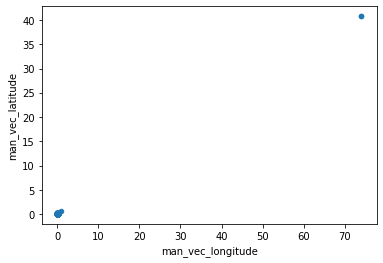

In [10]:
train['man_distance'] = train.man_vec_longitude + train.man_vec_latitude
test['man_distance'] = test.man_vec_longitude + test.man_vec_latitude
plot = train.iloc[:2000].plot.scatter('man_vec_longitude', 'man_vec_latitude')

In [11]:
def haversine_vectors(df):
   lat1 = df.pickup_latitude
   lon1 = df.pickup_longitude
   lat2 = df.dropoff_latitude
   lon2 = df.dropoff_longitude
   phi1 = np.radians(lat1)
   phi2 = np.radians(lat2)
   hv_lat = np.radians(lat2 - lat1)
   hv_lon = np.radians(lon2 - lon1)

   df['harvesine_latitude'] = hv_lat
   df['harvesine_longitude'] = hv_lon

haversine_vectors(train)

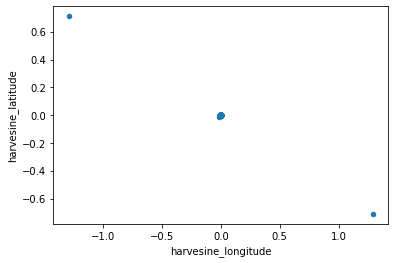

In [12]:
plot = train.iloc[:2000].plot.scatter('harvesine_longitude','harvesine_latitude')

In [13]:
train = train[(train.man_vec_longitude < 5.0) & (train.man_vec_latitude < 5.0)]
train = train[(train.harvesine_longitude < 0.1) & (train.harvesine_latitude < 0.1) & (train.harvesine_longitude > -0.1) & (train.harvesine_latitude > -0.1)]

## Exploratory Data Analysis

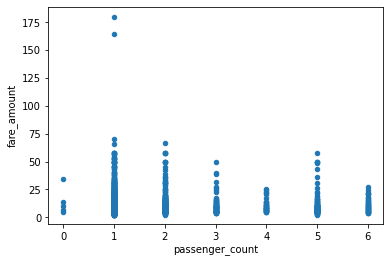

In [14]:
plot = train.iloc[:2000].plot.scatter('passenger_count', 'fare_amount')

In [15]:
train = train[(train.fare_amount >=0)]
train = train[(train.fare_amount <= 75)]
train = train[(train.passenger_count > 0)]
train = train[(train.passenger_count < 7)]

In [16]:
train['isTrain'] = 1
test['isTrain'] = 0
train = train.append(test)

In [17]:
def separate_time_zone(df):

    def append_columns(df,new_column_name,new):
        df[new_column_name] = new

    year=[]
    month=[]
    day=[]
    hour=[]
    minutes=[]
    seconds=[]
    time_zone =[]
    counter = 0

    datetime_column = df['pickup_datetime']
    for i in datetime_column:
        date_time_obj = datetime.datetime.strptime(i , '%Y-%m-%d %H:%M:%S %Z').replace(tzinfo=pytz.UTC)
        year.append(date_time_obj.year)
        month.append(date_time_obj.month)
        day.append(date_time_obj.day)
        hour.append(date_time_obj.hour)
        minutes.append(date_time_obj.minute)
        seconds.append(date_time_obj.second)
        time_zone.append(date_time_obj.tzinfo)
        counter += 1
        
    append_columns(df,'year',year)
    append_columns(df,'month',month)
    append_columns(df,'day',day)
    append_columns(df,'hour',hour)
    append_columns(df,'minute',minutes)
    append_columns(df,'second',seconds)
    append_columns(df,'time_zone',time_zone)
    
    return df

train = separate_time_zone(train)

In [18]:
train['key'] = pd.to_datetime(train.key)
train['weekday'] = train['key'].dt.dayofweek

In [19]:
train['time_period'] = 0
train.loc[(train.hour >= 5) & (train.hour <= 11) ,'time_period']= 0
train.loc[(train.hour >= 12)& (train.hour <= 17) ,'time_period']= 1
train.loc[(train.hour >= 18)& (train.hour <= 22) ,'time_period']= 2
train.loc[(train.hour >= 23) | (train.hour <= 4) ,'time_period']= 3

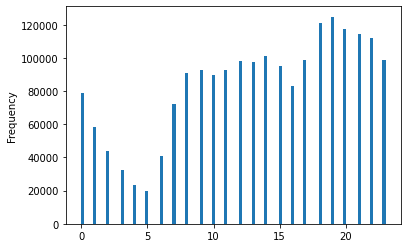

In [20]:
plot = train.hour.plot.hist(bins=100 , alpha= 1)

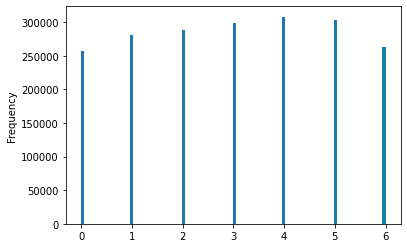

In [21]:
plot = train.weekday.plot.hist(bins=100 , alpha= 1)

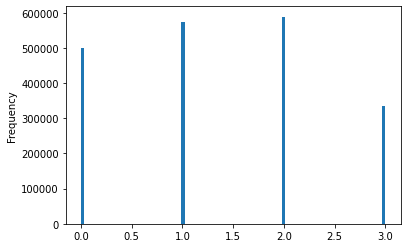

In [22]:
plot = train.time_period.plot.hist(bins=100 , alpha= 1)

In [23]:
jfk = (-73.7822222222, 40.6441666667)
nyc = (-74.0063889, 40.7141667)


def distance(lat1, lon1,lat2, lon2):
   r = 3956
   phi1 = np.radians(lat1)
   phi2 = np.radians(lat2)
   hv_lat = np.radians(lat2 - lat1)
   hv_lon = np.radians(lon2 - lon1)

   a = np.sin(hv_lat / 2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(hv_lon/ 2)**2
   c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
   res = r * c

   return round(res,2)

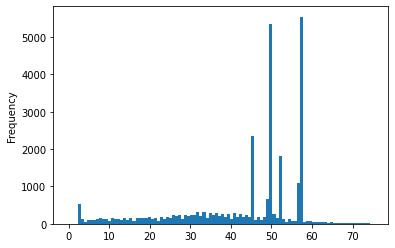

In [24]:
pickup_jfk = distance(train.pickup_latitude, train.pickup_longitude, jfk[1], jfk[0]) < 1.5
plot = train[pickup_jfk].fare_amount.plot.hist(bins=100 , alpha= 1)

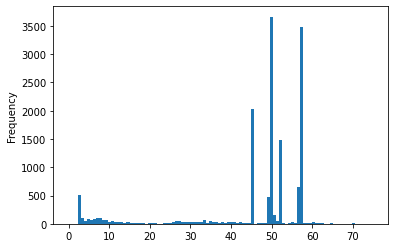

In [25]:
dropoff_jfk = distance(train.dropoff_latitude, train.dropoff_longitude, jfk[1], jfk[0]) < 1.5
plot = train[dropoff_jfk].fare_amount.plot.hist(bins=100 , alpha= 1)

In [26]:
train['pickup'] = pickup_jfk
train['dropoff'] = dropoff_jfk
train['JFK'] = 0 

train.loc[(train.fare_amount <= 45) & (train.fare_amount <= 59) & train.dropoff == True ,'JFK']= 1
train.loc[(train.fare_amount <= 45) & (train.fare_amount <= 59) & train.pickup == True ,'JFK']= 1

train = train.drop(['pickup','dropoff'],axis = 1)


In [27]:
ewr = (-74.175, 40.69)
lgr = (-73.87, 40.77)

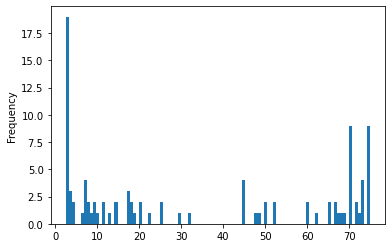

In [28]:
pickup_ewr = distance(train.pickup_latitude, train.pickup_longitude, ewr[1], ewr[0]) < 1.5
plot = train[pickup_ewr].fare_amount.plot.hist(bins=100 , alpha= 1)

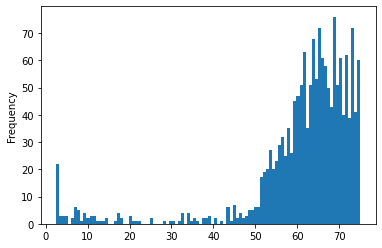

In [29]:
dropoff_ewr = distance(train.dropoff_latitude, train.dropoff_longitude, ewr[1], ewr[0]) < 1.5
plot = train[dropoff_ewr].fare_amount.plot.hist(bins=100 , alpha= 1)

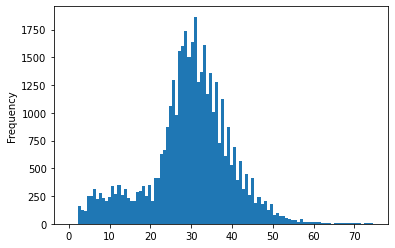

In [30]:
pickup_lgr = distance(train.pickup_latitude, train.pickup_longitude, lgr[1], lgr[0]) < 1.5
plot = train[pickup_lgr].fare_amount.plot.hist(bins=100 , alpha= 1)

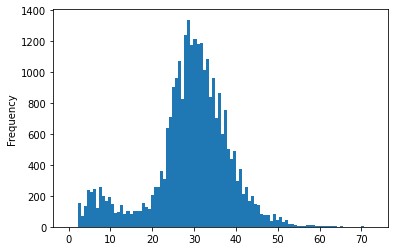

In [31]:
dropoff_lgr = distance(train.dropoff_latitude, train.dropoff_longitude, lgr[1], lgr[0]) < 1.5
plot = train[dropoff_lgr].fare_amount.plot.hist(bins=100 , alpha= 1)

In [32]:
train['pickup'] = pickup_ewr
train['dropoff'] = dropoff_ewr
train['EWR'] = 0 

train.loc[(train.fare_amount <= 55) & (train.fare_amount <= 77) & train.dropoff == True ,'EWR']= 1
train.loc[(train.fare_amount <= 55) & (train.fare_amount <= 77) & train.pickup == True ,'EWR']= 1

train = train.drop(['pickup','dropoff'],axis = 1)

train['pickup'] = pickup_lgr
train['dropoff'] = dropoff_lgr
train['LGR'] = 0 

train.loc[(train.fare_amount <= 25) & (train.fare_amount <= 35) & train.dropoff == True ,'LGR']= 1
train.loc[(train.fare_amount <= 25) & (train.fare_amount <= 35) & train.pickup == True ,'LGR']= 1

train = train.drop(['pickup','dropoff'],axis = 1)

In [33]:
train['distance_to_center']= distance(nyc[1], nyc[0], train.pickup_latitude, train.pickup_longitude)

In [34]:
train['distance_mile'] = distance(train.pickup_latitude,train.pickup_longitude, train.dropoff_latitude, train.dropoff_longitude)

In [35]:
def rush_hour_finder(df):
    def append_columns(df,new_column_name,new):
        df[new_column_name] = new
    rush_hour = []
    hour_column = df['hour']
    for hour in hour_column:
        if hour >= 7 and hour <= 9:
            rush_hour.append(1)
        elif hour >= 18 and hour <= 20:
            rush_hour.append(1)
        else:
            rush_hour.append(0)
            
    append_columns(df,'rush_hour',rush_hour)
    
    return df
train = rush_hour_finder(train)

In [36]:
test = train[(train.isTrain == 0)]
train = train[(train.isTrain == 1)]
train = train[(train.distance_to_center <= 20) & (train.distance_mile <= 35)]
features = ['distance_mile','man_distance','JFK','LGR','EWR','pickup_longitude', 'pickup_latitude','dropoff_longitude','dropoff_latitude','year','month','day','hour','minute','time_period','weekday']

X = train[features]
y = train['fare_amount']

## Modeling

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle= True)

In [38]:
y

0           4.5
1          16.9
2           5.7
3           7.7
4           5.3
           ... 
1999995     4.0
1999996     7.0
1999997    10.5
1999998    10.9
1999999    12.9
Name: fare_amount, Length: 1947570, dtype: float64

### Linear Regression

In [39]:
model_lin = Pipeline((
        ("standard_scaler", StandardScaler()),
        ("lin_reg", LinearRegression()),
    ))
model_lin.fit(X_train, y_train)

y_pred = model_lin.predict(X_test)

In [40]:
linear_acc = model_lin.score(X_test, y_test)
print('Linear Regression Accuracy: ', round(linear_acc*100,2), '%')

Linear Regression Accuracy:  79.77 %


### Random Forest

In [ ]:
rf = RandomForestRegressor(n_estimators = 400, random_state = 42, verbose= True, n_jobs = 6)
rf.fit(X_train, y_train)

[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:  3.5min
[Parallel(n_jobs=6)]: Done 188 tasks      | elapsed: 15.9min
[Parallel(n_jobs=6)]: Done 400 out of 400 | elapsed: 32.8min finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=400, n_jobs=6,
                      oob_score=False, random_state=42, verbose=True,
                      warm_start=False)

In [ ]:
y_pred = rf.predict(X_test)

[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    9.3s
[Parallel(n_jobs=6)]: Done 188 tasks      | elapsed:   42.0s
[Parallel(n_jobs=6)]: Done 400 out of 400 | elapsed:  1.5min finished


In [ ]:
rf_acc = rf.score(X_test, y_test)
print('Random Forest Regression Accuracy: ', round(rf_acc*100,2), '%')

[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:   14.1s
[Parallel(n_jobs=6)]: Done 188 tasks      | elapsed:   57.9s
Random Forest Regression Accuracy:  88.19 %
[Parallel(n_jobs=6)]: Done 400 out of 400 | elapsed:  2.0min finished


### XGBoost

In [41]:
data_dmatrix = xgb.DMatrix(data=X,label=y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, subsample = 1 ,learning_rate = 0.2,
                max_depth = 9, alpha = 10, n_estimators = 100)          

In [42]:
xg_reg.fit(X_train,y_train)

XGBRegressor(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.3, gamma=0,
             importance_type='gain', learning_rate=0.2, max_delta_step=0,
             max_depth=9, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

In [43]:
xgbr_acc = xg_reg.score(X_test, y_test)
print('XGBoost Regression Accuracy: ', round(xgbr_acc*100,2), '%')

XGBoost Regression Accuracy:  87.75 %


## Submission

In [44]:
test_key = test['key']
test_df = test[features]

In [48]:
models = [(model_lin, 'Linear'), (xg_reg, 'XGboost')]
submission =pd.read_csv('/gdrive/My Drive/Colab Notebooks/DS340W_Project/submission.csv')
for model, name in models:
    prediction = model.predict(test_df)      
    submission['fare_amount'] = prediction
    submission.to_csv(f'submission_{name}')
    

In [49]:
prediction = xg_reg.predict(test_df) 

In [50]:
submission =pd.read_csv('/gdrive/My Drive/Colab Notebooks/DS340W_Project/sample_submission.csv')

In [51]:
submission['fare_amount'] = prediction

In [52]:
submission.to_csv(f'submission_xgboost.csv', index = False )